In [4]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import pickle

def write_data_to_disk(file, data):
    with open(file, 'wb') as fid:
        pickle.dump(data, fid)


def load_data_from_disk(file):
    with open(file, 'rb') as fid:
        data = pickle.load(fid)
    return data

In [5]:
 def ISC(r, t):
    if_r = r
    if_t = t
    alpha = 0.94
    beta = 2.37
    q = 0.33

    f0 = 1 / (1 + (q * (if_r ** alpha))) ** beta
    x = if_t / if_r

    q1 = 1 / (1 - f0)
    k = 1.23
    s = (f0 / 2) + ((1 - (f0 / 2)) / (1 + (q1 * (x ** (-k)))))
    S = round(s * 100, 2)
    return S

def isc_pacs_inside_year(pacs_X_dict):
    ''' Recebe un dict de pacs com fi  {pac1: fi1, pac2: fi2, ...}
        Gera um dict de isc de comparar todos os pacs que recebeu  { ref: {obj: isc } }
        {pr_1: {pt_1: isc_11, pt_2: isc_12, ...}, pr_2: {pt_1: isc_21, pt_2: isc_22, ...} }'''
    
    M = {}
    for pac_r, fi_r in pacs_X_dict.items(): 
        # print('{} ref: {}').format(pac_r, fi_r))
        r = fi_r
        m = {}
        for pac_t, fi_t in pacs_X_dict.items():
            # print('{} obj: {}').format(pac_t, fi_t))
            t = fi_t
            indice = ISC(r,t)
            # print('{} - {}:  {}'.format(pac_r, pac_t, indice))
            m[pac_t] = indice
        M[pac_r] = m   # matriz em dict
    # print('isc dict:', M)                                      # {pac_r: {pac_t: 59.24,.. }}
    # dm = pd.DataFrame.from_dict(M)  
    # rint(dm)  # imprime a matriz de isc do formato dataframe
    return M

def isc_m50_pacs(M_dict_isc):
    ''' Recebe um dict (matriz de isc's)
    {pr_1: {pt_1: isc_11, pt_2: isc_12}, pr_2: {pt_1: isc_21, pt_2: isc_22}}
    
    Gera um dict com isc's maiores que 50% no mesmo formato de [M_dict_isc]
    {pr_1: {pt_2: isc_12}, pr_2: {pt_1: isc_21}},
     onde isc_12 e isc_21 > 50% '''
    
    K = {}
    for pr, values in M_dict_isc.items():
        k = {}
        for po in values:
            if values[po] > 50:
                k[po] = values[po]
                K[pr] = k
    return K

def isc_m50_pacs_values(M_dict_isc):
    Kv = []
    for pr, values in M_dict_isc.items():
        for po in values:
            if values[po] > 50:
                Kv.append(values[po])
    return Kv

def isc_m50_pacs_v2(M_dict_isc):
    ''' Recebe um dict (matriz de isc's)
    {pr_1: {pt_1: isc_11, pt_2: isc_12}, pr_2: {pt_1: isc_21, pt_2: isc_22}}
    
    Gera um dict com isc's maiores que 50% no mesmo formato de [M_dict_isc]
    {(pr_1, pt_2): isc_12, (pr_2, pt_1): isc_21},
     onde isc_12 e isc_21 > 50% '''
    
    K = {}
    for pr, values in M_dict_isc.items():
        for po in values:
            if values[po] > 50:
                K[pr, po] = values[po]
    return K


def mean_isc_year(K_dict_v2):
    ''' Recebe um dict do tipo {(pr, po): isc1_m50, (pr, po): isc2_m50} da func isc_m50_pacs_v2
    calcula a media dos isc , a saída é um unico valor para uma matriz de um nao'''
    media = [] 
    for pr_o, value in K_dict_v2.items():
        media.append(value)

    mean = round(sum(media)/len(media), 2)
    # print(mean)
    return mean

def max_isc_year(K_dict):
#     Max_p = {}

    Im = {}
    for pr, values in K_dict.items():
        po_m = max(values, key=values.get)
        Im[pr, po_m] = values[po_m] # max de cada pac_r  
    # print('\nmax de cada pac_r', Im)

    pr_po_max = max(Im, key=Im.get)  # max de todos os pac_r

    Max_p = Im[pr_po_max]

    return Max_p


def main(revista):
    fi_pacs50 = load_data_from_disk('Dict_fi_pacs50art_years_revistas/' + revista+ '_dic_fi_pacs50art_years.pk')

    K_years = {}
    K_mean = {}
    K_max = {}

    for ano, pacs in fi_pacs50.items():
        # print(ano)
        M = isc_pacs_inside_year(pacs)
        # print('\nisc dict: ', M)  # ****   
        
        K = isc_m50_pacs(M)
        
        K1= isc_m50_pacs_v2(M)
        
        K2 =isc_m50_pacs_values(M)
        # print('\nisc v2 > 50 dict: ', K2) # ****
        # print(pd.DataFrame.from_dict(K2, orient='index', columns=['isc >50']))
        
        p_max = max_isc_year(K)
        p_mean = mean_isc_year(K1)
        
        K_years[ano]= K2
        K_mean[ano] = p_mean
        K_max[ano] = p_max

    #print(K_years)
    return K_years, K_mean, K_max


In [6]:
def convert(rev_isc):
    g = {}
    for key, values in rev_isc.items():
        j = {}
        for k, val in values.items():
            j[int(k)] = val
        g[key]= j

    #print(g)
    return g

In [7]:
def boxplot_pacs_inside(revista):
    dict_data, dict_mean, dict_max = main(revista)
    pm = pd.DataFrame.from_dict(dict_mean, orient='index', columns=['mean'])
    pma = pd.DataFrame.from_dict(dict_max, orient='index', columns=['max'])
    
    labels, data = [*zip(*dict_data.items())]
    
    referencia = ['PRA', 'PRB', 'PRC', 'PRD', 'PRE', 'PRL']
    for ref in referencia:
        if ref != revista:
            rev_isc = load_data_from_disk('XvsY_isc_revistas/' + revista + 'vs' + ref + '_isc_years.pk')
            dit = convert(rev_isc)
            d_rev = pd.DataFrame(dit)
            dr = d_rev[50 < d_rev]

            pcc = pd.concat([pma, dr], axis=1, sort=True)

            pcc.plot(ls='-', marker='o', color=['blue', 'red','grey' ,'slategray', 'cornflowerblue', 'lightcoral', 'slategray', 'cadetblue', 'burlywood'])
            medianp= dict(linewidth=1, color='black')
            bplot = plt.boxplot(data,positions=labels, showfliers=False, medianprops=medianp)
            
            for i, v in dict_data.items():
                di = sorted(v, reverse=True)
                y = di[0:5]
                x = [i, i, i, i, i] 
                plt.scatter(x, y, s=10, marker='o', facecolors='none', edgecolors='k')

            plt.title(revista)
            plt.xlim(1985, 2016)
            plt.xticks(rotation='vertical', fontsize=9)
            plt.xlabel('Anos')
            plt.ylabel('Índice de sucesso de citação (%)')
            #plt.savefig('prb_f.png', dpi=300)
            plt.show()


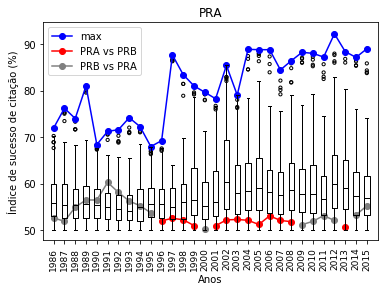

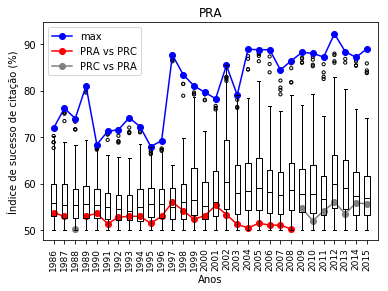

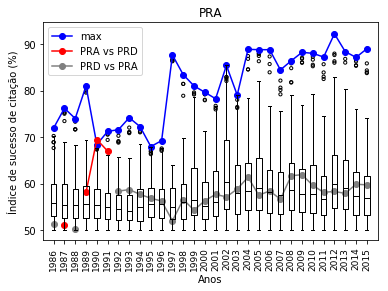

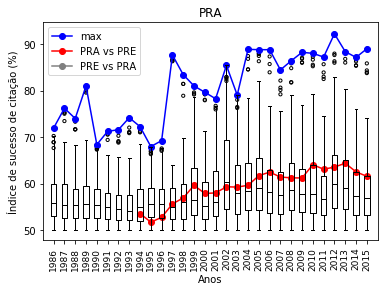

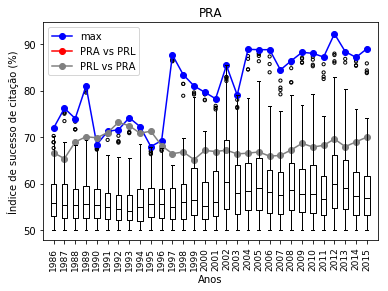

In [8]:
boxplot_pacs_inside('PRA')